In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.special import factorial as fac
from scipy.special import factorial2 as fac2
from scipy.integrate import quad, dblquad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

### Functions for computing Hermite coefficients

In [2]:
# Functions for computing normalized probabilists hermite coefficients
# Define standard normal measure
w = lambda x: (1/np.sqrt(2*np.pi))*np.exp(-(x**2)/2)

def hermite_coeff(n, act, l = -np.inf, u = np.inf):
    H_n = special.hermite(n)
    h_n = lambda x: (1/np.sqrt(fac(n)))*(2**(-n/2))*H_n(x/np.sqrt(2))
    f = lambda x: act(x)*h_n(x)*w(x)
    result,err = integrate.quad(f, l, u)
    return result, err


def comp_hermite_coeffs(N,act):
    coeffs = np.empty(N+1)
    errs = np.empty(N+1)
    for n in np.arange(0,N+1):
        coeffs[n], errs[n] = hermite_coeff(n, act)
    return coeffs, errs

### Classes for NTK power series calculations

In [3]:
class truncated_NTK():
    """
    Approximates the NTK via a truncation of its power series.
    """

    def __init__(self, act, L, T, gw, gb, vw, init_EOC = False):
        """
        Parameter descriptions:
        - act: string detailing activation function used
        - L: positive integer detailing number of hidden layers
        - T: positive integer indicating truncation point of the NTK power series
        - gw: float/double describing variance of weight initialization in first hidden layer
        - gb: float/double describing variance of bias initialization in first hidden layer (note must have gw+gb=1)
        - vw: float/double describing variance of weight
        - init_EOC: boolean, if true/false then calculate vb such that achieve EOC / unit variance initialization respectively
        
        """
        self.tol = 10**-7
        self.L = L
        self.act = act
        self.activation()
        self.T = T

        # Initialization conditions
        self.gw = gw
        self.gb = gb
        if init_EOC:
            print("Attempting initialization on the EOC...")
            # Initialize weight variance hyperparameter so that lies on the EOC
            self.vw = 1 / gauss_expectation(lambda z: self.dphi(np.sqrt(self.fq) * z) ** 2, ndim=1, fast=True)
            # Initilize bias variance so that have variance fixed at fq at each layer, default is 1.
            self.vb = self.fq - self.vw * gauss_expectation(lambda z: self.phi(np.sqrt(self.fq) * z) ** 2, ndim=1, fast=True)

            if self.vb < 0:
                if self.vb > -self.tol:
                    self.vb = 0
                else:
                    print(self.vb)
                    raise ValueError(
                          "The bias variance vb cannot be smaller than 0, consider choosing a different activation function")
            else:
                print("...initialization successful!")

        else:
            print("Attempting unit variance initializing...")
            self.vw = vw
            integrand = lambda x: (self.phi(x)**2)*(1/np.sqrt(2*np.pi))*np.exp(-(x**2)/2)
            integral, error = self.vw*integrate.quad(integrand, -np.infty, np.infty)
            self.vb = 1 - integral
            print("Network hyperparameters: gw=" + str(self.gw) + ", gb=" + str(self.gb) + ", vw=" + str(self.vw) + ", vb=" + str(self.vb))
            if (self.gw < 0) or (self.gb < 0) or (self.vw < 0) or (self.vb < 0):
                raise ValueError(
                        "Invalid hyperparameter and activation combination for unit variance initialization.")
            print("...initialization successful!")

        # Compute coefficients
        self.hermite_coeffs,_ = comp_hermite_coeffs(self.T,self.phi)
        self.hermite_coeffs_dphi,_ = comp_hermite_coeffs(self.T,self.dphi)        
        self.alphas, self.upsilons, self.kappas = self.compute_coeffs()


    def compute_coeffs(self):
        # Initialize coefficient arrays L x T
        alphas = np.empty((self.L, self.T+1))
        upsilons = np.empty((self.L, self.T+1))
        kappas = np.empty((self.L, self.T+1))
    
        # Compute coefficients for first hidden layer
        alphas[0] = self.vw*(self.hermite_coeffs**2)
        alphas[0,0] = alphas[0,0] + self.vb
        upsilons[0] = self.vw*(self.hermite_coeffs_dphi**2)
        kappas[0,0] = alphas[0,0] + self.gb*upsilons[0,0]
        for i in np.arange(1,self.T+1):
            kappas[0,i] = alphas[0,i] + + self.gb*upsilons[0,i] + self.gw*upsilons[0,i-1] 

        # Compute coefficients in subsequent layers
        for l in np.arange(1,self.L):
            F_array = self.comp_F_array(alphas[l-1])
            for p in range(self.T+1):
                alphas[l,p] = sum(alphas[0]*F_array[p])
                upsilons[l,p] = sum(upsilons[0]*F_array[p])
            for p in range(self.T+1):
                kappas[l,p] = alphas[l,p]
                for q in np.arange(0,p+1):
                    kappas[l,p] += kappas[l-1,q]*upsilons[l,p-q]
        return alphas, upsilons, kappas

  
    def comp_F_array(self, v):
        F_array = np.empty((self.T+1, self.T+1)) #rows are values of p, columns values of k so F(p,k) = F_array[p, k]
        # If k is zero then F(p,0) = 0, F(0,0) = 1
        F_array[:,0] = np.zeros(self.T+1)
        F_array[0,0] = 1
        for k in np.arange(1,self.T+1):
            if k == 1:
                F_array[:,1] = v
            else:
                for p in range(self.T+1):
                    F_array[p,k] = 0
                    for q in np.arange(0,p+1):
                        F_array[p,k] += v[q]*F_array[p-q,k-1]
        return F_array


    def evaluate(self, rho):
        outputs = np.empty(self.L)
        for l in range(self.L):
            outputs[l] = sum(np.array([rho**p for p in range(self.T)])*self.kappas[l])
        return outputs

    def compute_chi(self):
        integrand = lambda x: (self.dphi(x)**2)*(1/np.sqrt(2*np.pi))*np.exp(-(x**2)/2)
        integral, error = integrate.quad(integrand, -np.infty, np.infty)
        return self.vw*integral


    def activation(self):
        if act == 'Tanh':
            self.phi = lambda x: np.tanh(x)
            self.dphi = lambda x: 1 - np.tanh(x)**2

        elif act == 'ReLU':
            self.phi = lambda x: max(0,x)
            self.dphi = lambda x: max(0,np.sign(x))

        elif act == "Sigmoid":
            self.phi = lambda x: 1/(1+np.exp(-x))
            self.dphi = lambda x: (1/(1+np.exp(-x)))*(1-(1/(1+np.exp(-x))))

        elif act == 'Elu':
            self.phi = lambda x: min(np.sign(x),0)*(np.exp(x)-1) + max(0,x)
            self.dphi = lambda x: min(np.sign(x),0)*(np.exp(x)) + max(0,np.sign(x))

        elif act == 'Gaussian':
            self.phi = lambda x: (1/np.sqrt(2*np.pi))*np.exp(-(x**2)/2)
            self.dphi = lambda x: -(x/np.sqrt(2*np.pi))*np.exp(-(x**2)/2)
        else:
            print("Activation function not recognized")


  

In [4]:
class truncated_relu_NTK():
    """
    Approximates specifically ReLU via truncated NTK power series. In comparison with truncated_NTK()
    uses closed form expressions for the Hermite coefficients of ReLU instead of numerical approximation and
    automatically initializes on the EOC / uses standard initialization.
    """

    def __init__(self, L, T, gw, gb):
        """
        Parameter descriptions:
        - L: positive integer detailing number of hidden layers
        - T: positive integer indicating truncation point of the NTK power series
        - gw: float/double describing variance of weight initialization in first hidden layer
        - gb: float/double describing variance of bias initialization in first hidden layer (note must have gw+gb=1)
        """
        self.L = L
        self.phi = lambda x: max(0,x)
        self.dphi = lambda x: max(0,np.sign(x))
        self.T = T
        self.gw = gw
        self.gb = gb    
        self.vw = 2
        self.vb = 0
        
        # Uses closed form expressions to compute the Hermite coefficients of ReLU
        self.hermite_coeffs_phi =np.empty(self.T)
        self.hermite_coeffs_phi[0] = 1/np.sqrt(2*np.pi)
        self.hermite_coeffs_phi[1] = 1/2
        for i in np.arange(2,self.T):
            if i%2 == 0:
                self.hermite_coeffs_phi[i] = fac2(i-3)/np.sqrt(2*np.pi*fac(i))
            else:
                self.hermite_coeffs_phi[i] = 0
        
        # Uses closed form expressions to compute the Hermite coefficients of the derivative of ReLU
        self.hermite_coeffs_dphi =np.empty(self.T)
        self.hermite_coeffs_dphi[0] = 1/2

        for i in np.arange(1,self.T):
            if i%2 == 0:
                self.hermite_coeffs_dphi[i] = 0
            else:
                self.hermite_coeffs_dphi[i] = fac2(i-2)/np.sqrt(2*np.pi*fac(i))

        self.alphas, self.upsilons, self.kappas = self.compute_coeffs()


    def compute_coeffs(self):
        alphas = np.empty((self.L, self.T))
        upsilons = np.empty((self.L, self.T))
        kappas = np.empty((self.L, self.T))
        # Compute coefficients at first hidden layer
        alphas[0] = self.vw*(self.hermite_coeffs_phi**2)
        alphas[0,0] = alphas[0,0] + self.vb
        upsilons[0] = self.vw*(self.hermite_coeffs_dphi**2)
        kappas[0,0] = alphas[0,0] + self.gb*upsilons[0,0]
        for i in np.arange(1,self.T):
            kappas[0,i] = alphas[0,i] + self.gw*upsilons[0,i-1] + self.gb*upsilons[0,i]
        # Compute coefficients at subsequent hidden layers
        for l in np.arange(1,self.L):
            F_array = self.comp_F_array(alphas[l-1])
            for p in range(self.T):
                alphas[l,p] = sum(alphas[0]*F_array[p])
                if (p < self.T):
                    upsilons[l,p] = sum(upsilons[0]*F_array[p,:self.T])

            for p in range(self.T):
                kappas[l,p] = alphas[l,p]
                for q in np.arange(0,p+1):
                    kappas[l,p] += kappas[l-1,q]*upsilons[l,p-q]
        return alphas, upsilons, kappas

  
    def comp_F_array(self, v):
        F_array = np.empty((self.T, self.T)) #rows are values of p, columns values of k so F(p,k) = F_array[p, k]
        # If k is zero then F(p,0) = 0, F(0,0) = 1
        F_array[:,0] = np.zeros(self.T)
        F_array[0,0] = 1
        for k in np.arange(1,self.T):
            if k == 1:
                F_array[:,1] = v
            else:
                for p in range(self.T):
                    F_array[p,k] = 0
                    for q in np.arange(0,p+1):
                        F_array[p,k] += v[q]*F_array[p-q,k-1]
        return F_array


    def evaluate(self, rho):
        outputs = np.empty(self.L)
        for l in range(self.L):
            outputs[l] = sum(np.array([rho**p for p in range(self.T)])*self.kappas[l])
        return outputs

In [5]:
class ntk_relu_explicit():
    """
    Class for computing NTK with ReLU activation function explicitly.
    """
    def __init__(self, L, fq=1):
        self.L = L # L is the number of hidden layers, total number of layers is L+1
        self.fq = fq # fixed point of variance function

    def corr_func_fixed(self, rho):
        return (rho/2)+(np.sqrt(1-rho**2) + rho*np.arcsin(rho))/np.pi

    def corr_func_diff_fixed(self, rho):
        return 0.5 + np.arcsin(rho)/np.pi

    def evaluate(self, rho):
        outputs = np.empty(self.L+1)
        rhos = np.empty(self.L+1)
        rhos[0] = rho
        outputs[0] = rho
        for l in range(self.L):
            rhos[l+1] = self.corr_func_fixed(rhos[l])
            outputs[l+1] = rhos[l+1] + outputs[l] * self.corr_func_diff_fixed(rhos[l])
        return outputs[1:]


## Error of Truncated ReLU NTK

In [6]:
L = 5
relu_ntk = ntk_relu_explicit(L)
relu_ntks_truncs = {}
Ts = [5,50]
for T in Ts:
    relu_ntks_truncs[T] = truncated_relu_NTK(L, T, 1, 0)

In [7]:
M = 200
rhos = np.linspace(-1,1,M)

outputs_relu_trunc = {}
for T in Ts:
    outputs_relu_trunc[T] = np.empty((M,L))

outputs_relu= np.empty((M,L))


for m in np.arange(M):
    outputs_relu[m] = relu_ntk.evaluate(rhos[m])
    for T in Ts:
        outputs_relu_trunc[T][m] = relu_ntks_truncs[T].evaluate(rhos[m])

In [8]:
Ls = [0,2,4]
errors = {}
for T in Ts:
    errors[T] = np.empty((L,M))
    for l in Ls:
        errors[T][l] = np.abs(outputs_relu[:,l] - outputs_relu_trunc[T][:,l])

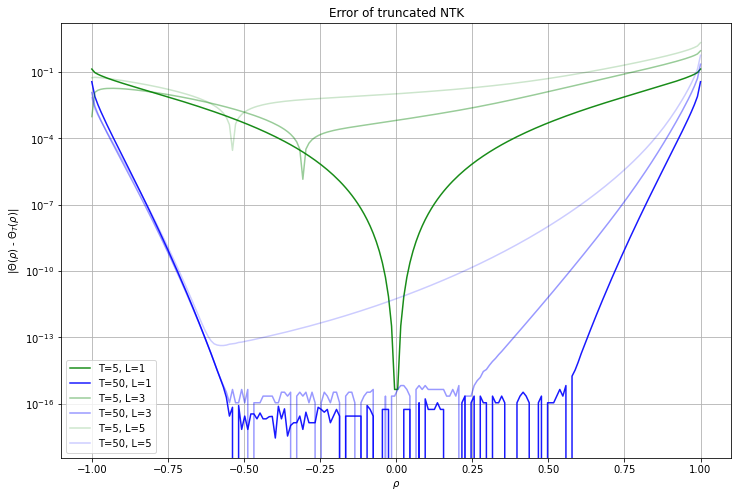

In [9]:
fig, ax = plt.subplots(1,1,figsize = (12,8))
cols = {5:'g', 50:'b'}
alph = {0:0.9, 2:0.4, 4:0.2}

for l in Ls:
    for T in [5,50]:
        sns.lineplot(x=rhos, y=errors[T][l],  label="T="+str(T) + ", L="+str(l+1), axes = ax, color = cols[T],alpha=alph[l])

ax.set_yscale('log')
ax.set(xlabel=r"$\rho$", ylabel = r"|$\Theta(\rho)$ - $\Theta_T(\rho)$|", title="Error of truncated NTK")
plt.grid(True)
plt.savefig("error_truncated_ntk.png")
plt.show()

## Error of Truncated ReLU NTK

In [10]:
N = 5
gw = 1/2
gb = 1/2
vw = 1

act_names = ['ReLU', 'Tanh', 'Sigmoid', 'Gaussian']
act_dict_ntks = dict.fromkeys(act_names, [])
act_dict_kappas = dict.fromkeys(act_names, [])

for act in act_names:
    act_dict_ntks[act] = truncated_NTK(act, 1, N, gw, gb, vw)


Attempting unit variance initializing...
Network hyperparameters: gw=0.5, gb=0.5, vw=1, vb=0.49999999999999956
...initialization successful!
Attempting unit variance initializing...
Network hyperparameters: gw=0.5, gb=0.5, vw=1, vb=0.6057055096021591
...initialization successful!
Attempting unit variance initializing...
Network hyperparameters: gw=0.5, gb=0.5, vw=1, vb=0.7066209641419072
...initialization successful!
Attempting unit variance initializing...
Network hyperparameters: gw=0.5, gb=0.5, vw=1, vb=0.9081118507630347
...initialization successful!


In [11]:
data = []
for act in act_names:
    data.append(np.cumsum(act_dict_ntks[act].kappas)/(1+ act_dict_ntks[act].compute_chi()))

data = 100*np.array(data)

displayN = 6
df=pd.DataFrame(data=data[:,:displayN], index=[act for act in act_names],columns=[str(i) for i in np.arange(displayN)])
df.head()

,0,1,2,3,4,5
ReLU,52.276996,82.582161,93.192491,94.076685,95.402976,95.800863
Tanh,53.888523,91.468259,93.725179,97.486712,98.154594,99.089628
Sigmoid,93.600034,99.729065,99.822221,99.977481,99.985746,99.997316
Gaussian,95.833608,96.798764,98.729077,99.091010,99.633911,99.747015


In [12]:
pd.options.display.precision = 3
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
      0 &       1 &       2 &       3 &       4 &       5 \\
\midrule
 52.277 &  82.582 &  93.192 &  94.077 &  95.403 &  95.801 \\
 53.889 &  91.468 &  93.725 &  97.487 &  98.155 &  99.090 \\
 93.600 &  99.729 &  99.822 &  99.977 &  99.986 &  99.997 \\
 95.834 &  96.799 &  98.729 &  99.091 &  99.634 &  99.747 \\
\bottomrule
\end{tabular}

